# Random Forest Model for Crop Type and Land Classification
> Using RandomForest Classifier for crop type mapping with data from Cloud Optimized Geotiffs (COGs). 

- toc: true
- badges: true
- author: Zhuang-Fang Yi
- comments: false

Using RandomForest Classifier for crop type mapping for SERVIR Sat ML training. 
This notebook showcase how we can read satellite imagery (Sentinal-2) from **AWS public S3** through AWS Public Data Program for crop type mapping.

- If you want to run this whole notebook on Google Colab, here is [the link](https://colab.research.google.com/drive/1NIuDieA5ep45hFboJFbaI3Lg6iZX5GFG).

- If you would like to replicate the workflow with the same data on your local machine, please download the data from our shared [Google Drive folder](https://drive.google.com/drive/folders/1jM2mBsJ81QfmyaKZNeXSTyi_IOVr_3Vs?usp=sharing).

Besides mapping crop type with RandomForestClassifier, we also prepared notebooks that use LightGBM and SVM.
- Find our [notebook for LightGBM](https://colab.research.google.com/drive/1wcz5PRDmM3MvSccqgb5WXpWmVuGB2jYh) on Google Colab;
- Find our [notebook for SVM](https://colab.research.google.com/drive/1Q1Wki8m4iL8q1hU3S4rr83c8V0dPTMLl) on Google Colab.


In [0]:
from os import path as op
import pickle

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

## Label data preparation

**TODOs**

*Add training dataset sourcing, creations*


In [0]:
# read in training data polygons that created as geojson
training_vectors = gpd.read_file('training_data.geojson')
training_vectors.head()

,name,description,geometry
0,Shadow,None,"MULTIPOLYGON (((34.83383 1.18204, 34.83577 1.1..."
1,Forestland,None,"MULTIPOLYGON (((35.30961 1.01328, 35.30964 1.0..."
2,Maize,early reproductive,"MULTIPOLYGON (((34.90904 1.09515, 34.90907 1.0..."
3,Sugarcane,no change..maize farm on the right and far lef...,"MULTIPOLYGON (((34.90750 1.08934, 34.90753 1.0..."
4,Maize,reproductive good crop,"MULTIPOLYGON (((34.87144 0.82953, 34.87147 0.8..."


In [0]:
# find all unique values of training data names to use as classes
classes = np.unique(training_vectors.name)
classes

array(['Built', 'Cloud', 'Fallow', 'Forestland', 'Grassland', 'Maize',
       'Shadow', 'Sugarcane', 'Sunflower', 'Waterbody'], dtype=object)

In [0]:
# create a dictionary to convert class names into integers for modeling
class_dict = dict(zip(classes, range(len(classes))))
class_dict                  

{'Built': 0,
 'Cloud': 1,
 'Fallow': 2,
 'Forestland': 3,
 'Grassland': 4,
 'Maize': 5,
 'Shadow': 6,
 'Sugarcane': 7,
 'Sunflower': 8,
 'Waterbody': 9}

## Reading COG from AWS 

**TODOs**
How to read Sentinel-2 from AWS public S3.

In [ ]:
# raster information
raster_file = 'Trans_nzoia_2019_05-02.tif'

## Model training

In [0]:



# a custom function for getting each value from the raster
def all_values(x):
    return x

# this larger cell reads data from a raster file for each training vector
X_raw = []
y_raw = []
with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.name, training_vectors.geometry):
        
        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint8',
            all_touched=True
        ).astype(bool)
        
        # for each label pixel (places where the mask is true)
        label_pixels = np.argwhere(mask)
        
        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw.append(one_x)
            # add the label to y
            y_raw.append(class_dict[label])


In [0]:
# convert the training data lists into the appropriate numpy array shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((160461, 6), (160461,))

In [0]:
# helper function for calculating ND*I indices (bands in the final dimension)
def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

ndvi = band_index(X, 3, 2)
ndwi = band_index(X, 1, 3)

X = np.concatenate([X, ndvi, ndwi], axis=1)
X.shape

(160461, 8)

In [0]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{0: 0.00046882325363338024,
 1: 0.001597444089456869,
 2: 0.0004928536224741252,
 3: 1.970093973482535e-05,
 4: 0.000819000819000819,
 5: 1.5704257424187697e-05,
 6: 0.0002473410833539451,
 7: 0.0002824858757062147,
 8: 0.05263157894736842,
 9: 0.003115264797507788}

In [0]:
# initialize a RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=200,
    class_weight=class_weight_dict,
    max_depth=6,
    n_jobs=-1,
    verbose=1,
    random_state=0)


In [0]:
# fit the model to the data (training)
clf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   22.6s finished


RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.00046882325363338024,
                                     1: 0.001597444089456869,
                                     2: 0.0004928536224741252,
                                     3: 1.970093973482535e-05,
                                     4: 0.000819000819000819,
                                     5: 1.5704257424187697e-05,
                                     6: 0.0002473410833539451,
                                     7: 0.0002824858757062147,
                                     8: 0.05263157894736842,
                                     9: 0.003115264797507788},
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jo

In [0]:
# predict on X_test to evaluate the model
preds = clf.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=labels)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished


In [0]:
# (optional) save the trained model as pickle file
model_name = 'random_forest.sav'
with open(model_name, 'wb') as modelfile:
    pickle.dump(clf, modelfile)

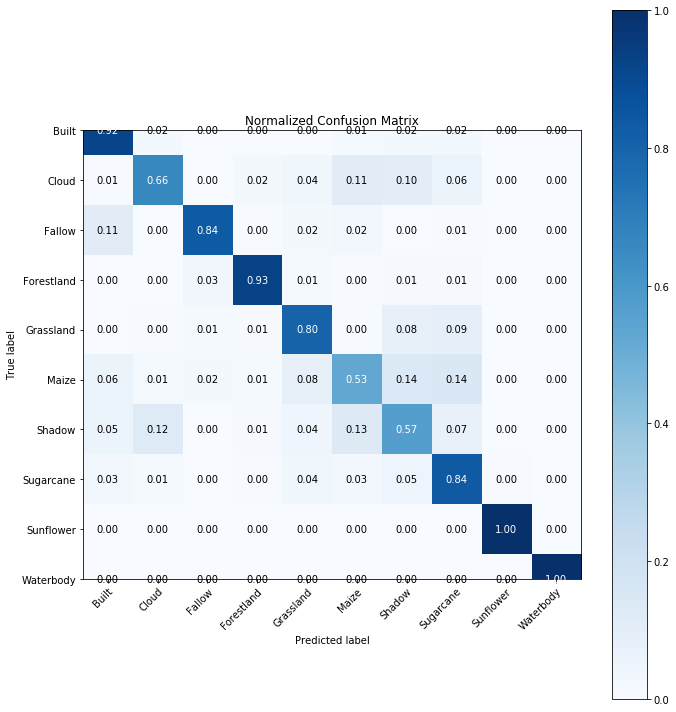

In [0]:
# plot the confusion matrix
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

In [0]:
# predict again with the tree interpreter to see how much each band contributes to the classification
sample = 100
prediction, bias, contributions = ti.predict(clf, X_test[:sample])
c = np.sum(contributions, axis=0)

In [0]:
# plot the contributions
band_names = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'NDVI', 'NDWI']

gdf = gpd.GeoDataFrame(c, columns=classes, index=band_names)
gdf.style.background_gradient(cmap='viridis')

,Built,Cloud,Fallow,Forestland,Grassland,Maize,Shadow,Sugarcane,Sunflower,Waterbody
Blue,-0.708147,-0.450384,-2.68955,5.93931,-0.460897,0.36023,-0.154207,-0.481766,-0.167871,-1.18672
Green,-1.09678,-0.00350109,-1.57525,2.95823,-0.336196,1.36762,0.551725,-0.218106,-0.732232,-0.915498
Red,-1.90573,-0.59379,0.277761,3.01317,0.223731,0.7112,-0.249443,-0.619405,-0.683663,-0.173831
NIR,0.0684765,-0.196796,-2.96226,2.66494,-0.747003,1.36166,0.791034,0.479715,-1.19875,-0.261016
SWIR1,0.166388,0.0139419,-1.05339,3.05759,-0.538389,0.81744,0.452637,0.357217,-0.771856,-2.50158
SWIR2,-0.734541,-0.460321,0.715332,2.85215,-0.179285,0.235555,-0.271136,-0.406578,-1.01603,-0.735149
NDVI,-0.919315,-0.238332,2.18171,3.64759,-0.992437,1.17432,-0.263332,-0.444098,-2.37513,-1.77098
NDWI,0.121986,0.0502156,0.987004,2.8981,-1.07648,0.740517,0.576891,-0.444139,-2.01388,-1.84022


## Generate predictions over the full image

Using the trained RandomForestClassifier `clf` over a new satellite image that cover a larger geospatial location.

In [0]:
# in this case, we predict over the entire input image
# (only small portions were used for training)
new_image = raster_file

output_image = "classification.tif"

with rasterio.open(new_image, 'r') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.uint8,
        count=1,
    )
    with rasterio.open(output_image, 'w', **profile) as dst:

        # perform prediction on each small image patch to minimize required memory
        patch_size = 500

        for i in range((src.shape[0] // patch_size) + 1):
            for j in range((src.shape[1] // patch_size) + 1):
                # define the pixels to read (and write) with rasterio windows reading
                window = rasterio.windows.Window(
                    j * patch_size,
                    i * patch_size,
                    # don't read past the image bounds
                    min(patch_size, src.shape[1] - j * patch_size),
                    min(patch_size, src.shape[0] - i * patch_size))
                
                # read the image into the proper format
                data = src.read(window=window)
                
                # adding indices if necessary
                img_swp = np.moveaxis(data, 0, 2)
                img_flat = img_swp.reshape(-1, img_swp.shape[-1])

                img_ndvi = norm_inds(img_flat, 3, 2)
                img_ndwi = norm_inds(img_flat, 1, 3)

                img_w_ind = np.concatenate([img_flat, img_ndvi, img_ndwi], axis=1)

                # remove no data values, store the indices for later use
                m = np.ma.masked_invalid(img_w_ind)
                to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])

                # skip empty inputs
                if not len(to_predict):
                    continue
                # predict
                img_preds = clf.predict(to_predict)

                # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
                # makes the assumption that all bands have identical no-data value arrangements
                output = np.zeros(img_flat.shape[0])
                output[~m.mask[:, 0]] = img_preds.flatten()
                # resize to the original image dimensions
                output = output.reshape(*img_swp.shape[:-1])

                # create our final mask
                mask = (~m.mask[:, 0]).reshape(*img_swp.shape[:-1])

                # write to the final files
                dst.write(output.astype(rasterio.uint8), 1, window=window)
                dst.write_mask(mask, window=window)